In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [39]:
print("GPU Available:", torch.cuda.is_available())

print(torch.__version__)


GPU Available: True
2.5.1


In [40]:
print(torch.version.cuda)

12.4


In [41]:
# Hyperparameters
batch_size = 64

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Split train_data into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [42]:
# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.relu = nn.ReLU().to(device=device)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1).to(device=device)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0).to(device=device)
        self.fc1 = nn.Linear(self.__Getsize_forFC(), 64).to(device=device)
        self.fc2 = nn.Linear(64, 10).to(device=device)
        
    def _cnnForward(self,x):
        x = self.conv1(x)        
        x = self.pool(self.relu(x))
        return x
    
    def __Getsize_forFC(self):
        x = torch.rand((1, 1, 28, 28)).to(device=device)
        with torch.no_grad():
            x = self._cnnForward(x)
        return x.reshape(-1,1).shape[0]
    
    def forward(self, x):
        x = self._cnnForward(x)
        x = x.view(-1, self.__Getsize_forFC())
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

In [43]:
# Train the model
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    return train_losses, train_accuracies, val_losses, val_accuracies


In [44]:
def evaluate_test_accuracy(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy


In [45]:
model = CNN().to(device)

learning_rate = 0.001

# Loss and optimizer
# criterion = nn.CrossEntropyLoss()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [46]:
num_epochs = 15
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1/15], Train Loss: 0.5598, Train Accuracy: 83.88%, Val Loss: 0.2354, Val Accuracy: 93.08%
Epoch [2/15], Train Loss: 0.1987, Train Accuracy: 94.10%, Val Loss: 0.1506, Val Accuracy: 95.67%
Epoch [3/15], Train Loss: 0.1338, Train Accuracy: 96.04%, Val Loss: 0.1224, Val Accuracy: 96.44%
Epoch [4/15], Train Loss: 0.1058, Train Accuracy: 96.85%, Val Loss: 0.1038, Val Accuracy: 97.03%
Epoch [5/15], Train Loss: 0.0904, Train Accuracy: 97.33%, Val Loss: 0.0900, Val Accuracy: 97.44%
Epoch [6/15], Train Loss: 0.0796, Train Accuracy: 97.56%, Val Loss: 0.0953, Val Accuracy: 97.22%
Epoch [7/15], Train Loss: 0.0726, Train Accuracy: 97.80%, Val Loss: 0.0835, Val Accuracy: 97.62%
Epoch [8/15], Train Loss: 0.0635, Train Accuracy: 98.04%, Val Loss: 0.0814, Val Accuracy: 97.60%
Epoch [9/15], Train Loss: 0.0598, Train Accuracy: 98.14%, Val Loss: 0.0800, Val Accuracy: 97.67%
Epoch [10/15], Train Loss: 0.0556, Train Accuracy: 98.32%, Val Loss: 0.0745, Val Accuracy: 97.83%
Epoch [11/15], Train Loss: 0.

In [47]:
test_accuracy = evaluate_test_accuracy(model, test_loader)

Test Accuracy: 97.78%


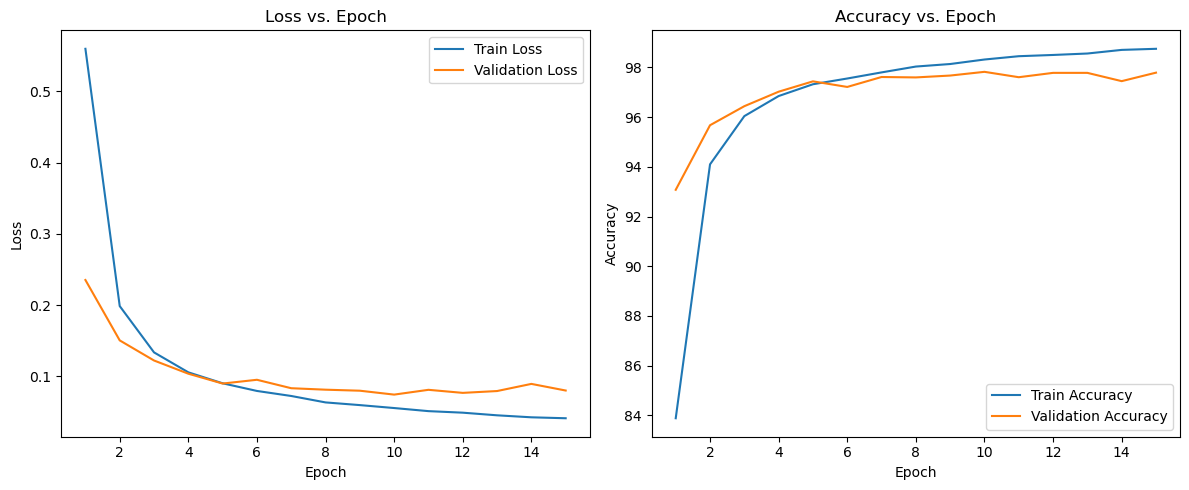

In [48]:
# Plot the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()


In [49]:
print(device)

cuda


## Practice

In [50]:
# Data transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize each RGB channel
])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train_data into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [51]:
# Define CNN model for CIFAR-10
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Adjusted for 3 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(-1, 128 * 4 * 4)  # Adjusted for CIFAR-10 image size
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)  # Log-softmax for NLLLoss

In [52]:
model = CIFAR10_CNN().to(device)

# Loss and optimizer
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
num_epochs = 5

# Run training and save the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1/5], Train Loss: 1.6164, Train Accuracy: 40.40%, Val Loss: 1.3641, Val Accuracy: 50.04%
Epoch [2/5], Train Loss: 1.2548, Train Accuracy: 54.49%, Val Loss: 1.2090, Val Accuracy: 55.83%
Epoch [3/5], Train Loss: 1.0730, Train Accuracy: 61.51%, Val Loss: 0.9975, Val Accuracy: 64.66%
Epoch [4/5], Train Loss: 0.9497, Train Accuracy: 66.22%, Val Loss: 0.9423, Val Accuracy: 67.00%
Epoch [5/5], Train Loss: 0.8766, Train Accuracy: 69.09%, Val Loss: 0.8815, Val Accuracy: 68.71%


In [54]:
test_accuracy = evaluate_test_accuracy(model, test_loader)

Test Accuracy: 69.86%


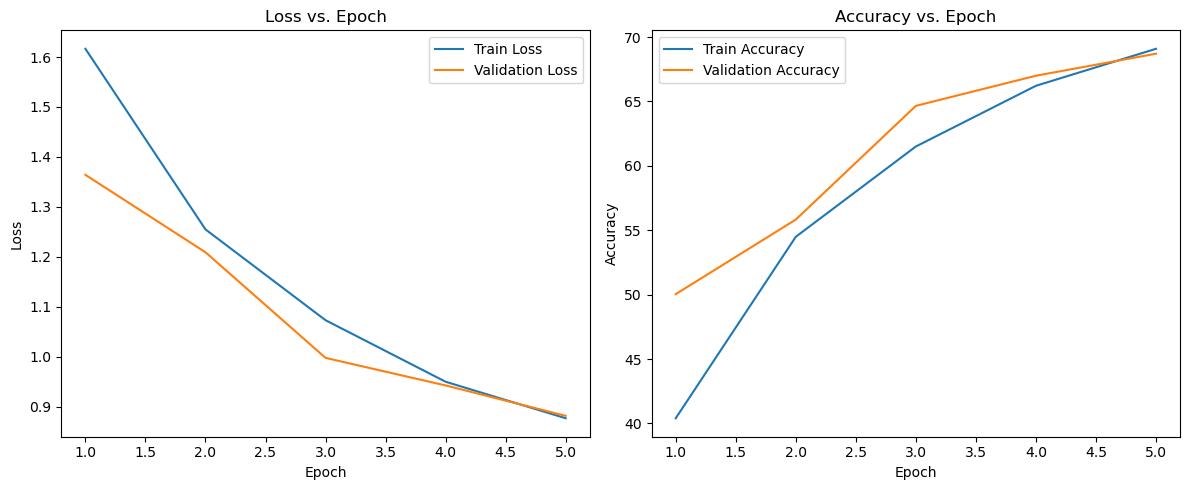

In [55]:
# Plot the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
# Define CNN model for CIFAR-10
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Adjusted for 3 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(-1, 256 * 2 * 2)  # Adjusted for CIFAR-10 image size
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)  # Log-softmax for NLLLoss

In [57]:
model = CIFAR10_CNN().to(device)

# Loss and optimizer
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [58]:
num_epochs = 5

# Run training and save the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1/5], Train Loss: 1.6375, Train Accuracy: 39.30%, Val Loss: 1.3918, Val Accuracy: 49.29%
Epoch [2/5], Train Loss: 1.2346, Train Accuracy: 55.34%, Val Loss: 1.1734, Val Accuracy: 58.02%
Epoch [3/5], Train Loss: 1.0333, Train Accuracy: 62.98%, Val Loss: 0.9293, Val Accuracy: 66.80%
Epoch [4/5], Train Loss: 0.9055, Train Accuracy: 67.70%, Val Loss: 0.8607, Val Accuracy: 70.44%
Epoch [5/5], Train Loss: 0.8138, Train Accuracy: 71.46%, Val Loss: 0.8465, Val Accuracy: 70.50%


In [59]:
test_accuracy = evaluate_test_accuracy(model, test_loader)

Test Accuracy: 71.27%


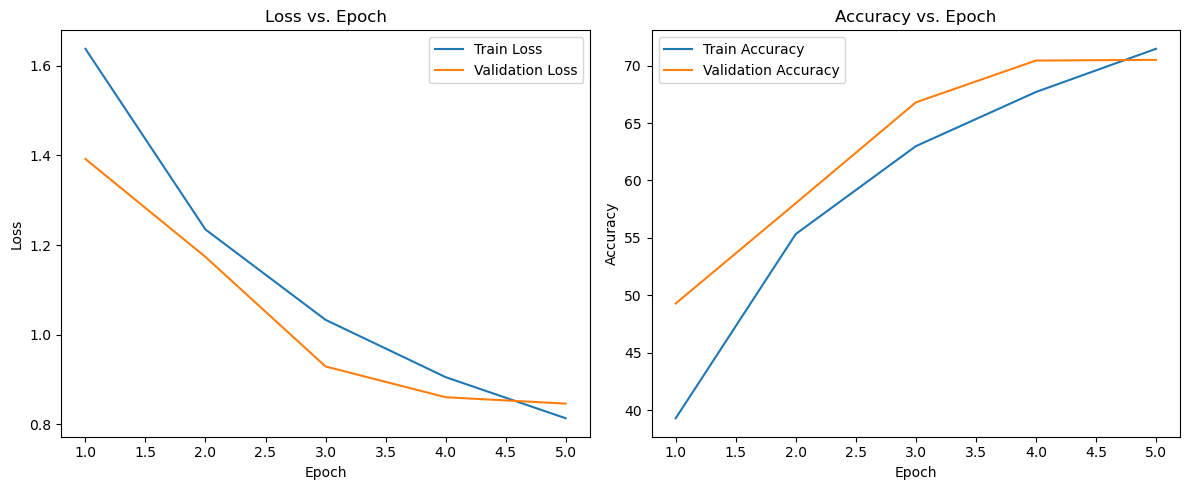

In [60]:
# Plot the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

<div dir='rtl'>
با افزایش لایه هم دقت برای داده های تست و هم برای داده های یادگیری افزایش یافت
</div>

In [61]:
# Define CNN model for CIFAR-10 with Batch Normalization
class CIFAR10_CNN(nn.Module):
    def __init__(self):
        super(CIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # Batch norm after conv1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch norm after conv2
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch norm after conv3
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)  # Batch norm after conv4
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 2 * 2, 256)
        self.fc2 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        x = self.pool(self.relu(self.bn4(self.conv4(x))))
        x = x.view(-1, 256 * 2 * 2)
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)  # Log-softmax for NLLLoss


In [62]:
model = CIFAR10_CNN().to(device)

# Loss and optimizer
learning_rate = 0.001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [63]:
num_epochs = 5

# Run training and save the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1/5], Train Loss: 1.3751, Train Accuracy: 49.48%, Val Loss: 1.1367, Val Accuracy: 59.70%
Epoch [2/5], Train Loss: 0.9977, Train Accuracy: 64.21%, Val Loss: 0.9650, Val Accuracy: 65.75%
Epoch [3/5], Train Loss: 0.8495, Train Accuracy: 69.92%, Val Loss: 0.8468, Val Accuracy: 70.31%
Epoch [4/5], Train Loss: 0.7651, Train Accuracy: 73.00%, Val Loss: 0.7909, Val Accuracy: 72.26%
Epoch [5/5], Train Loss: 0.7103, Train Accuracy: 75.17%, Val Loss: 0.7324, Val Accuracy: 74.25%


In [64]:
test_accuracy = evaluate_test_accuracy(model, test_loader)

Test Accuracy: 73.96%


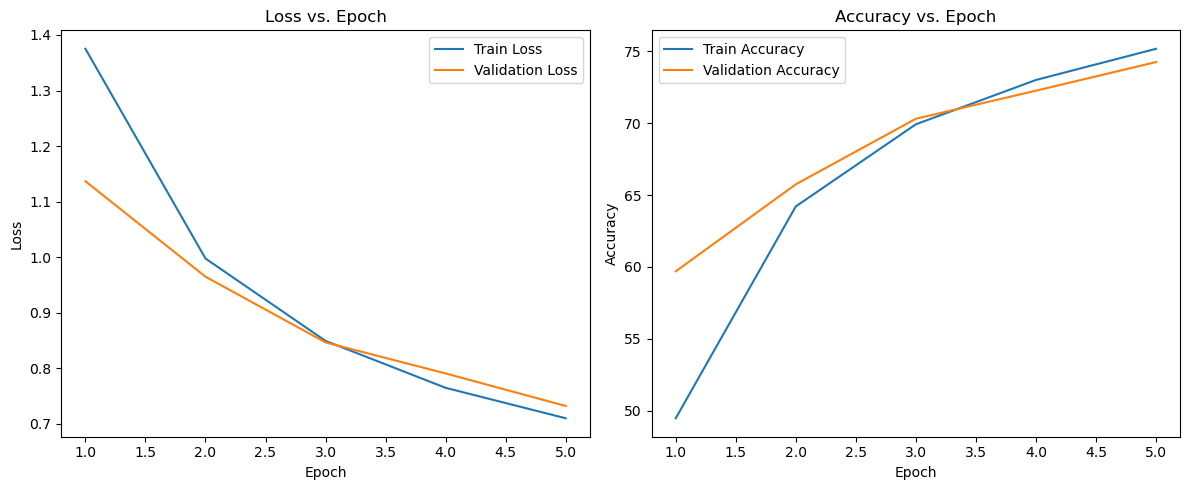

In [65]:
# Plot the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [70]:
class EnhancedCIFAR10_CNN(nn.Module):
    def __init__(self):
        super(EnhancedCIFAR10_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(512 * 2 * 2, 512)
        self.fc2 = nn.Linear(512, 10)
        self.swish = nn.SiLU()  # Swish activation

    def forward(self, x):
        x = self.pool(self.swish(self.bn1(self.conv1(x))))
        x = self.pool(self.swish(self.bn2(self.conv2(x))))
        x = self.pool(self.swish(self.bn3(self.conv3(x))))
        x = self.pool(self.swish(self.bn4(self.conv4(x))))
        x = x.view(-1, 512 * 2 * 2)
        x = self.swish(self.dropout(self.fc1(x)))
        x = self.fc2(x)
        return torch.log_softmax(x, dim=1)

In [71]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split train_data into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [77]:
model = EnhancedCIFAR10_CNN().to(device)

# Loss and optimizer
learning_rate = 0.0001
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [78]:
num_epochs = 5

# Run training and save the metrics
train_losses, train_accuracies, val_losses, val_accuracies = train(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

Epoch [1/5], Train Loss: 1.4199, Train Accuracy: 48.19%, Val Loss: 1.1310, Val Accuracy: 60.09%
Epoch [2/5], Train Loss: 1.0539, Train Accuracy: 62.66%, Val Loss: 0.9633, Val Accuracy: 66.26%
Epoch [3/5], Train Loss: 0.9128, Train Accuracy: 67.81%, Val Loss: 0.8853, Val Accuracy: 69.53%
Epoch [4/5], Train Loss: 0.8280, Train Accuracy: 70.85%, Val Loss: 0.8123, Val Accuracy: 71.24%
Epoch [5/5], Train Loss: 0.7582, Train Accuracy: 73.39%, Val Loss: 0.7227, Val Accuracy: 74.80%


In [79]:
test_accuracy = evaluate_test_accuracy(model, test_loader)

Test Accuracy: 74.69%


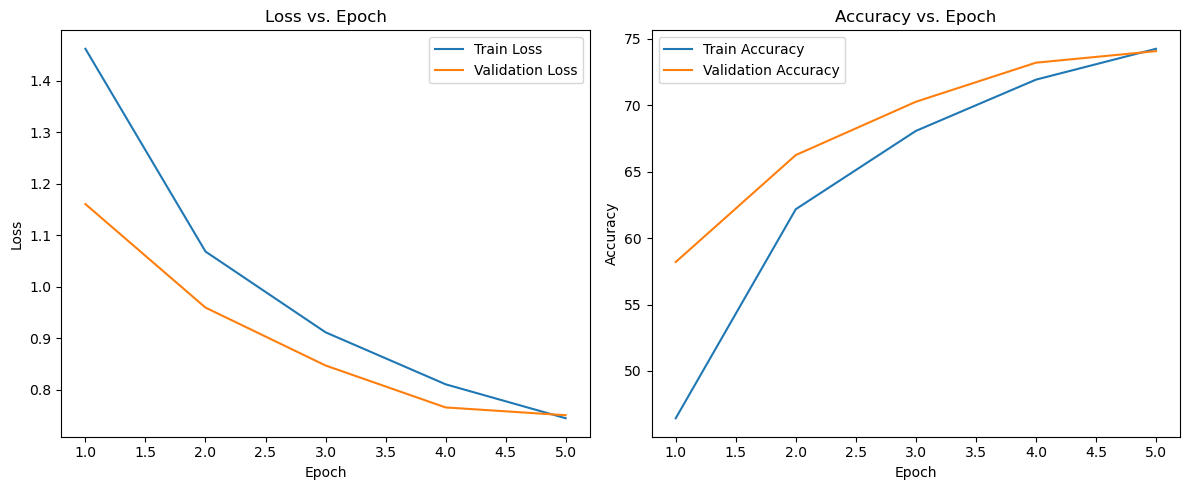

In [76]:
# Plot the results
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.tight_layout()
plt.show()

<div rtl='rtl'>
با افزایش لایه و اضافه کردن بچ نرمالیزیشن دقت افزایش زیادی نداشت.
</div>